# Starbucks Capstone Challenge

## Project Overview


This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

My task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. 

## Data Sets

Dataset overview
 - The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.
 - Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.
 - As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.
 - There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.
 - The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### 1. Libraries and raw data Load

In [1]:
!pip install datetime

    85% |███████████████████████████▎    | 51kB 2.6MB/s eta 0:00:01    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 174kB 11.3MB/s ta 0:00:01


In [2]:
#import libraries
import datetime
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
% matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 2. Data Exploration

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [12]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

### 3. Data Preprocessing

#### Profile
 - make id column to index
 - change data type of became_member_on column to datetime type
 - make new column('membership_period') which means the period from registration date to now (2019-01-01)
 - make dummy columns('F', 'M' and 'O') from gender column

In [13]:
def get_df_profile(profile):
    df_profile = profile.set_index(['id'], drop = True).dropna()
    df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')
    now = datetime.datetime.strptime("2019-01-01", "%Y-%m-%d")
    
    membership_period_list = []
    for idx in df_profile.index:
        time_delta = now - datetime.datetime.fromtimestamp(df_profile.at[idx, 'became_member_on'].timestamp())
        membership_period_list.append(time_delta.days)
    df_profile['membership_period'] = membership_period_list
    
    df_gender = pd.get_dummies(df_profile['gender'].apply(pd.Series).stack()).sum(level=0)
    df_profile = pd.concat([df_profile, df_gender], axis = 1, sort = False)
    
    return df_profile

In [14]:
df_profile = get_df_profile(profile)
df_profile.head()

,age,became_member_on,gender,income,membership_period,F,M,O
id,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,F,112000.0,535,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,F,100000.0,602,1,0,0
e2127556f4f64592b11af22de27a7932,68,2018-04-26,M,70000.0,250,0,1,0
389bc3fa690240e798340f5a15918d5c,65,2018-02-09,M,53000.0,326,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,58,2017-11-11,M,51000.0,416,0,1,0


In [15]:
person_ids = list(df_profile.index)

#### Portfolio
 - rename id column to offer_id column
 - make dummy columns('email', 'mobile', 'social' and 'web') from channels column
 - make offer_name column to understand easily characteristics which the offer has

In [16]:
def get_df_portfolio(portfolio):
    df_portfolio = portfolio.rename(columns={'id': 'offer_id'})
    df_channels = pd.get_dummies(df_portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
    
    df_portfolio = pd.concat([df_portfolio, df_channels], axis = 1, sort = False)
    df_portfolio = df_portfolio.drop(columns=['channels'])
    
    offer_name_list = []
    for idx in df_portfolio.index:
        offer_name = []
        offer_name.append(df_portfolio.at[idx, 'offer_type'])
        offer_name.append('dur' + str(df_portfolio.at[idx, 'duration']))
        offer_name.append('dif' + str(df_portfolio.at[idx, 'difficulty']))
        offer_name.append('rew' + str(df_portfolio.at[idx, 'reward']))
        offer_name_list.append('_'.join(offer_name))
        
    df_portfolio['offer_name'] = offer_name_list
    return df_portfolio

In [17]:
df_portfolio = get_df_portfolio(portfolio)
df_portfolio

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,offer_name
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,bogo_dur7_dif10_rew10
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,bogo_dur5_dif10_rew10
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,informational_dur4_dif0_rew0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,bogo_dur7_dif5_rew5
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,discount_dur10_dif20_rew5
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,discount_dur7_dif7_rew3
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,discount_dur10_dif10_rew2
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,informational_dur3_dif0_rew0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,bogo_dur5_dif5_rew5
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,discount_dur7_dif10_rew2


#### Transcript
 - divide transcript into df_offer and df_transaction
 - In df_offer, make offer_id and reward columns from value column
 - In df_transaction, make amount column from value column

In [18]:
transcript = transcript.loc[transcript['person'].isin(person_ids)]

In [19]:
def get_df_offer(df_transcript):
    events = list(df_transcript['event'].unique())
    events.remove('transaction')
    
    df_offer = transcript.loc[transcript['event'].isin(events)].reset_index(drop=True)
    
    offer_id_list = []
    reward_list = []
    for idx in df_offer.index:
        if df_offer.at[idx, 'event'] == 'offer completed':
            offer_id_list.append(df_offer.at[idx, 'value']['offer_id'])
            reward_list.append(df_offer.at[idx, 'value']['reward'])
        else:
            offer_id_list.append(df_offer.at[idx, 'value']['offer id'])
            reward_list.append(np.nan)
    df_offer['offer_id'] = offer_id_list
    df_offer['reward'] = reward_list
    
    df_offer = df_offer.drop(columns=['value']).rename(columns={'person': 'person_id'})
    
    return df_offer

In [20]:
df_offer = get_df_offer(transcript)
df_offer.head()

,event,person_id,time,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
2,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [21]:
def get_df_transaction(df_transcript):
    
    df_transaction = transcript.loc[transcript['event'] == 'transaction'].reset_index(drop=True)
    
    amount_list = []
    for idx in df_transaction.index:
        amount_list.append(df_transaction.at[idx, 'value']['amount'])
    df_transaction['amount'] = amount_list
    
    df_transaction = df_transaction.drop(columns=['event', 'value']).rename(columns={'person': 'person_id'})
    
    return df_transaction

In [22]:
df_transaction = get_df_transaction(transcript)
df_transaction.head()

,person_id,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


### 4. Data Visualization

#### Characteristic of Profile

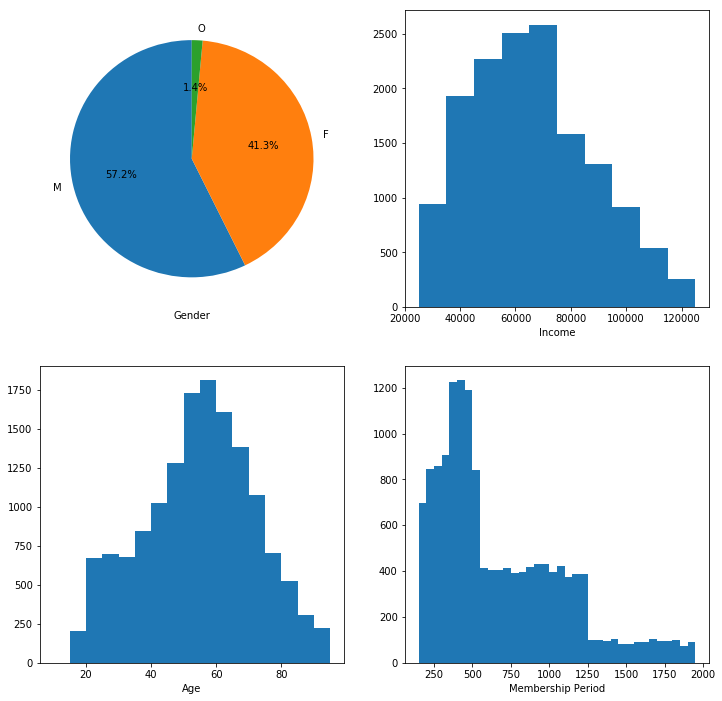

In [23]:
fig, ax = plt.subplots(2, 2, figsize = [12, 12])

ax[0, 0].pie(df_profile['gender'].value_counts().values, labels=list(df_profile['gender'].value_counts().index), startangle=90, autopct='%1.1f%%')
ax[0, 0].set_xlabel('Gender')

ax[1, 0].hist(data = df_profile, x = 'age', bins = np.arange(10, 100, 5))
ax[1, 0].set_xlabel('Age')

ax[0, 1].hist(data = df_profile, x = 'income', bins = np.arange(25000, 130000, 10000))
ax[0, 1].set_xlabel('Income')

ax[1, 1].hist(data = df_profile, x = 'membership_period', bins = np.arange(150, 2000, 50))
ax[1, 1].set_xlabel('Membership Period')

plt.show()

#### Relationship between Profile and Number of events

In [24]:
offer_received_counts = df_offer.loc[df_offer['event'] == 'offer received']['person_id'].value_counts().rename('n_offer_received')
offer_viewed_counts = df_offer.loc[df_offer['event'] == 'offer viewed']['person_id'].value_counts().rename('n_offer_viewed')
offer_completed_counts = df_offer.loc[df_offer['event'] == 'offer completed']['person_id'].value_counts().rename('n_offer_completed')
transaction_counts = df_transaction['person_id'].value_counts().rename('n_transaction')
profile_event_counts = pd.concat([df_profile, offer_received_counts, offer_viewed_counts, offer_completed_counts, transaction_counts], axis=1, sort=False).fillna(0)
profile_event_counts.head()

,age,became_member_on,gender,income,membership_period,F,M,O,n_offer_received,n_offer_viewed,n_offer_completed,n_transaction
0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,F,112000.0,535,1,0,0,2.0,0.0,1.0,3.0
78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,F,100000.0,602,1,0,0,4.0,4.0,3.0,7.0
e2127556f4f64592b11af22de27a7932,68,2018-04-26,M,70000.0,250,0,1,0,4.0,3.0,2.0,3.0
389bc3fa690240e798340f5a15918d5c,65,2018-02-09,M,53000.0,326,0,1,0,6.0,6.0,5.0,3.0
2eeac8d8feae4a8cad5a6af0499a211d,58,2017-11-11,M,51000.0,416,0,1,0,3.0,2.0,1.0,4.0


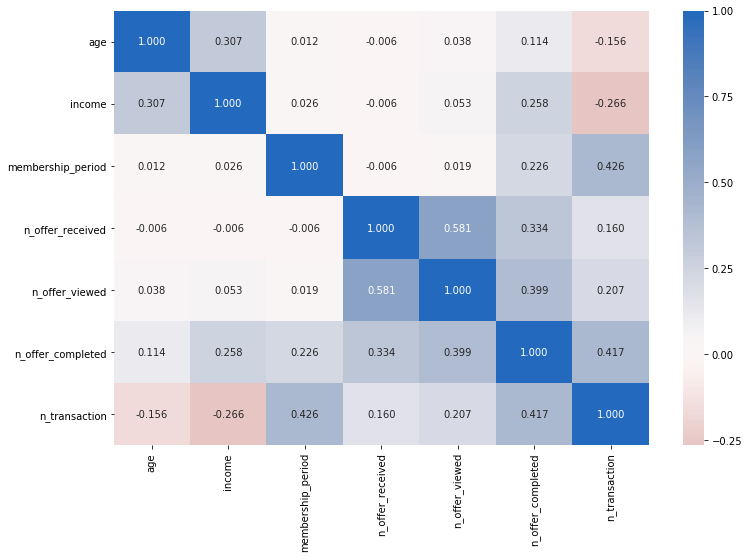

In [25]:
# Correlation plot
numeric_vars = ['age', 'income', 'membership_period', 'n_offer_received', 'n_offer_viewed', 'n_offer_completed', 'n_transaction']
plt.figure(figsize = [12, 8])
sb.heatmap(profile_event_counts[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0)
plt.show()

#### Relationship between Gender and Number of events

In [26]:
F_event_counts = pd.DataFrame(profile_event_counts.loc[profile_event_counts['gender'] == 'F'].mean().iloc[6:]).rename(columns={0: 'F'})
M_event_counts = pd.DataFrame(profile_event_counts.loc[profile_event_counts['gender'] == 'M'].mean().iloc[6:]).rename(columns={0: 'M'})
O_event_counts = pd.DataFrame(profile_event_counts.loc[profile_event_counts['gender'] == 'O'].mean().iloc[6:]).rename(columns={0: 'O'})

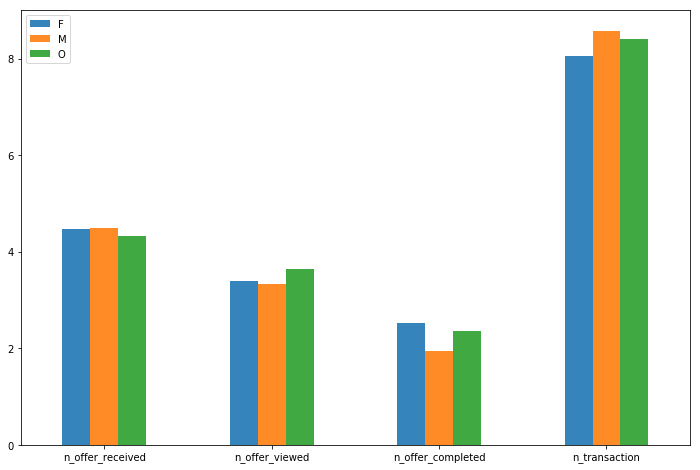

In [27]:
pd.concat([F_event_counts, M_event_counts, O_event_counts], axis=1, sort=False).plot(kind='bar',alpha=0.9, rot=0, figsize=(12, 8))
plt.show();

#### Histogram of offer events and offer promotion

In [29]:
offer_transaction_portfolio = df_offer.merge(df_portfolio, on='offer_id')
offer_transaction_portfolio.head()

,event,person_id,time,offer_id,reward_x,difficulty,duration,offer_type,reward_y,email,mobile,social,web,offer_name
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,bogo_dur7_dif5_rew5
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,bogo_dur7_dif5_rew5
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,bogo_dur7_dif5_rew5
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,bogo_dur7_dif5_rew5
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,bogo_dur7_dif5_rew5


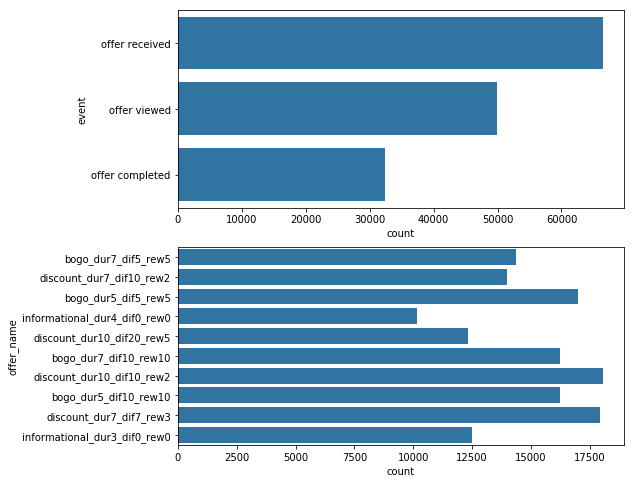

In [30]:
fig, ax = plt.subplots(nrows=2, figsize = [8, 8])

default_color = sb.color_palette()[0]
sb.countplot(data = offer_transaction_portfolio, y = 'event', color = default_color, ax = ax[0])
sb.countplot(data = offer_transaction_portfolio, y = 'offer_name', color = default_color, ax = ax[1])
plt.show()

#### Relationship between offer events and offer promotions

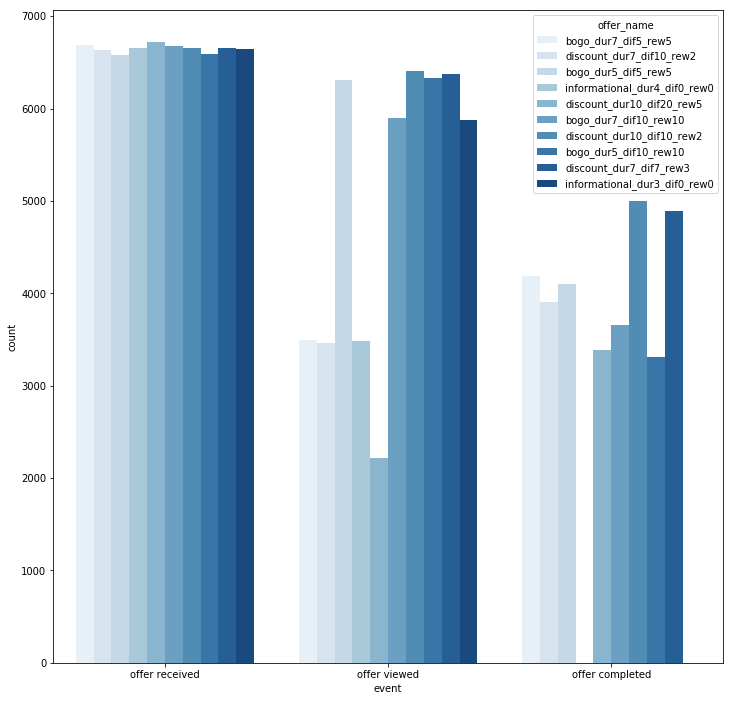

In [31]:
plt.figure(figsize = [12, 12])
sb.countplot(data = offer_transaction_portfolio, x = 'event', hue = 'offer_name', palette = 'Blues')
plt.show()

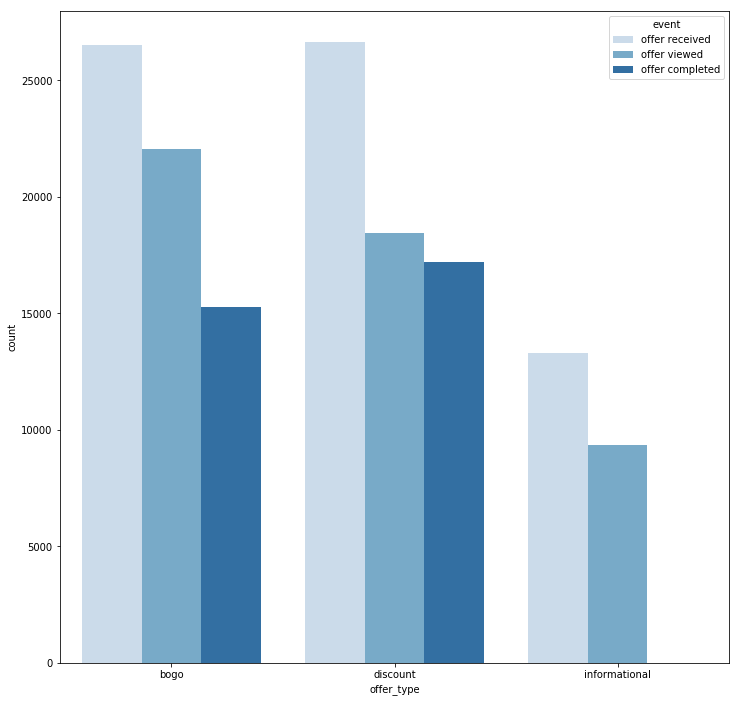

In [32]:
plt.figure(figsize = [12, 12])
sb.countplot(data = offer_transaction_portfolio, x = 'offer_type', hue = 'event', palette = 'Blues')
plt.show()

In [35]:
bogo_receivd = len(offer_transaction_portfolio.loc[(offer_transaction_portfolio['offer_type'] == 'bogo') & (offer_transaction_portfolio['event'] == 'offer received')])
bogo_viewed = len(offer_transaction_portfolio.loc[(offer_transaction_portfolio['offer_type'] == 'bogo') & (offer_transaction_portfolio['event'] == 'offer viewed')])
bogo_completed = len(offer_transaction_portfolio.loc[(offer_transaction_portfolio['offer_type'] == 'bogo') & (offer_transaction_portfolio['event'] == 'offer completed')])

discount_receivd = len(offer_transaction_portfolio.loc[(offer_transaction_portfolio['offer_type'] == 'discount') & (offer_transaction_portfolio['event'] == 'offer received')])
discount_viewed = len(offer_transaction_portfolio.loc[(offer_transaction_portfolio['offer_type'] == 'discount') & (offer_transaction_portfolio['event'] == 'offer viewed')])
discount_completed = len(offer_transaction_portfolio.loc[(offer_transaction_portfolio['offer_type'] == 'discount') & (offer_transaction_portfolio['event'] == 'offer completed')])

informational_receivd = len(offer_transaction_portfolio.loc[(offer_transaction_portfolio['offer_type'] == 'informational') & (offer_transaction_portfolio['event'] == 'offer received')])
informational_viewed = len(offer_transaction_portfolio.loc[(offer_transaction_portfolio['offer_type'] == 'informational') & (offer_transaction_portfolio['event'] == 'offer viewed')])

In [41]:
print('Ratio of viewed and received in BOGO : ', bogo_viewed/bogo_receivd)
print('Ratio of completed and viewed in BOGO : ', bogo_completed/bogo_viewed)
print('Ratio of viewed and received in Discount : ', discount_viewed/discount_receivd)
print('Ratio of completed and viewed in Discount : ', discount_completed/discount_viewed)
print('Ratio of viewed and received in Informational : ', informational_viewed/informational_receivd)

Ratio of viewed and received in BOGO :  0.8305008101895467
Ratio of completed and viewed in BOGO :  0.6923181632560461
Ratio of viewed and received in Discount :  0.6923567356735674
Ratio of completed and viewed in Discount :  0.9309354856183305
Ratio of viewed and received in Informational :  0.7037593984962406


#### Relationship between offer events and BOGO promotions

In [43]:
bogo_transaction_portfolio = offer_transaction_portfolio.loc[offer_transaction_portfolio['offer_type'] == 'bogo']

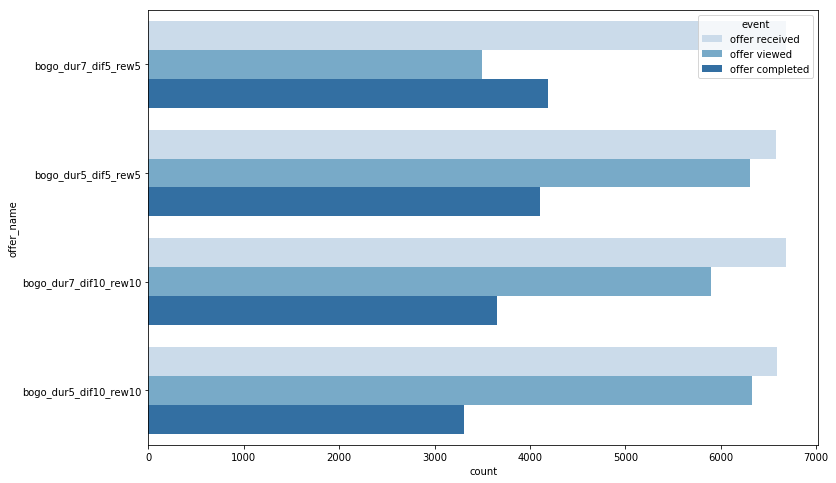

In [44]:
plt.figure(figsize = [12, 8])
sb.countplot(data = bogo_transaction_portfolio, y = 'offer_name', hue = 'event', palette = 'Blues')
plt.show()

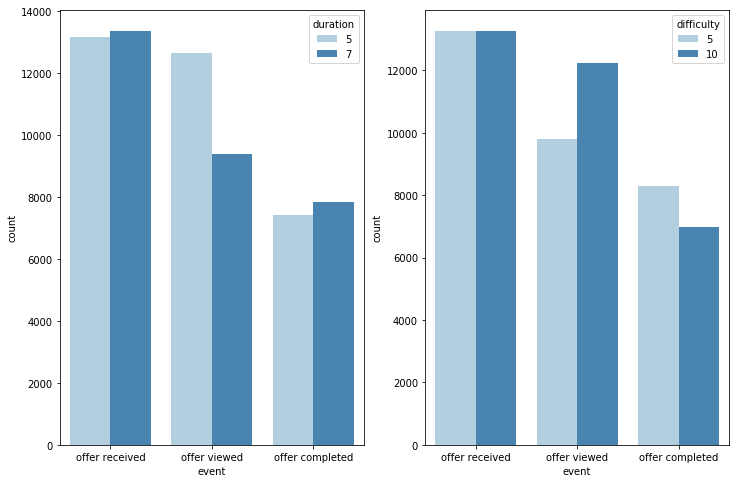

In [45]:
fig, ax = plt.subplots(1, 2, figsize = [12, 8])

sb.countplot(data = bogo_transaction_portfolio, x = 'event', hue = 'duration', palette = 'Blues', ax = ax[0])
# In BOGO case, reward is the same with the difficulty
sb.countplot(data = bogo_transaction_portfolio, x = 'event', hue = 'difficulty', palette = 'Blues', ax = ax[1])

plt.show()

#### Relationship between offer events and Discount promotions

In [46]:
discount_transaction_portfolio = offer_transaction_portfolio.loc[offer_transaction_portfolio['offer_type'] == 'discount']

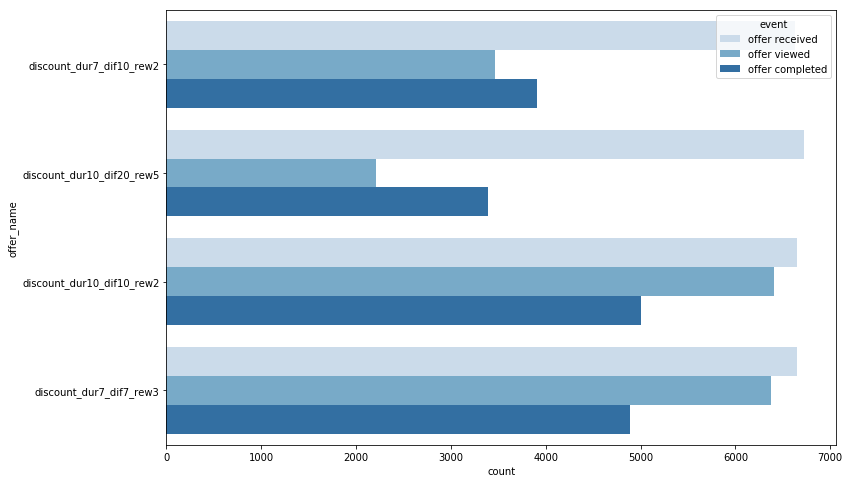

In [47]:
plt.figure(figsize = [12, 8])
sb.countplot(data = discount_transaction_portfolio, y = 'offer_name', hue = 'event', palette = 'Blues')
plt.show()

### 5. Implementation

#### Classification by Logistic Regression

- Independent variable : age, income, membership_period, gender, n_offer_received, n_offer_viewed
- Dependent variable : ratio of viewed and received in category
- class : 0 (Ratio of viewed and received <= 0.8 (Median))
- class : 1 (Ratio of viewed and received > 0.8 (Median))

In [65]:
profile_viewed_received = profile_event_counts.loc[profile_event_counts['n_offer_received'] != 0][['age', 'income', 'membership_period', 'F', 'M', 'O', 'n_offer_received', 'n_offer_viewed']]

In [66]:
profile_viewed_received['r_viewed_received'] = profile_viewed_received['n_offer_viewed'] / profile_viewed_received['n_offer_received']
profile_viewed_received.head()

,age,income,membership_period,F,M,O,n_offer_received,n_offer_viewed,r_viewed_received
0610b486422d4921ae7d2bf64640c50b,55,112000.0,535,1,0,0,2.0,0.0,0.000000
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,602,1,0,0,4.0,4.0,1.000000
e2127556f4f64592b11af22de27a7932,68,70000.0,250,0,1,0,4.0,3.0,0.750000
389bc3fa690240e798340f5a15918d5c,65,53000.0,326,0,1,0,6.0,6.0,1.000000
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,416,0,1,0,3.0,2.0,0.666667


In [67]:
profile_viewed_received.describe()

,age,income,membership_period,F,M,O,n_offer_received,n_offer_viewed,r_viewed_received
count,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000
mean,54.389069,65406.882591,681.460594,0.413293,0.572402,0.014305,4.487247,3.364372,0.753525
std,17.383172,21598.059614,419.244076,0.492441,0.494747,0.118749,1.071711,1.290055,0.236454
min,18.000000,30000.000000,159.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,49000.000000,367.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.600000
50%,55.000000,64000.000000,517.000000,0.000000,1.000000,0.000000,5.000000,3.000000,0.800000
75%,66.000000,80000.000000,956.000000,1.000000,1.000000,0.000000,5.000000,4.000000,1.000000
max,101.000000,120000.000000,1982.000000,1.000000,1.000000,1.000000,6.000000,6.000000,1.000000


In [68]:
profile_viewed_received['category_viewed_received'] = [1 if x > 0.8 else 0 for x in profile_viewed_received['r_viewed_received'].values]

In [69]:
x = profile_viewed_received[['age', 'F', 'M', 'O', 'income', 'membership_period', 'n_offer_received']]
y = profile_viewed_received['category_viewed_received']

In [70]:
log_reg = LogisticRegression()
log_reg.fit(x, y)
y_pred = log_reg.predict(x)

##### Performance

In [71]:
print('Accuracy of classification :', metrics.accuracy_score(profile_viewed_received['category_viewed_received'].values, y_pred))

Accuracy of classification : 0.596086369771


In [72]:
cnf_metrix = metrics.confusion_matrix(profile_viewed_received['category_viewed_received'].values, y_pred)
print('Confusion_matrix :')
print(cnf_metrix)

Confusion_matrix :
[[8834    0]
 [5986    0]]


In [73]:
print(metrics.classification_report(profile_viewed_received['category_viewed_received'].values, y_pred, target_names=['class 0', 'class 1']))

             precision    recall  f1-score   support

    class 0       0.60      1.00      0.75      8834
    class 1       0.00      0.00      0.00      5986

avg / total       0.36      0.60      0.45     14820



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- Independent variable : age, income, membership_period, gender, n_offer_received, n_offer_viewed, n_offer_completed
- Dependent variable : ratio of completed and viewed in category
- class : 0 (Ratio of completed and viewed <= 0.67 (Median))
- class : 1 (Ratio of completed and viewed > 0.67 (Median))

In [74]:
profile_completed_viewed = profile_event_counts.loc[profile_event_counts['n_offer_viewed'] != 0][['age', 'income', 'membership_period', 'F', 'M', 'O', 'n_offer_received', 'n_offer_viewed', 'n_offer_completed']]

In [75]:
profile_completed_viewed['r_completed_viewed'] = [1 if x > 1 else x for x in (profile_completed_viewed['n_offer_completed'] / profile_completed_viewed['n_offer_viewed']).values]
profile_completed_viewed.head()

,age,income,membership_period,F,M,O,n_offer_received,n_offer_viewed,n_offer_completed,r_completed_viewed
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,602,1,0,0,4.0,4.0,3.0,0.750000
e2127556f4f64592b11af22de27a7932,68,70000.0,250,0,1,0,4.0,3.0,2.0,0.666667
389bc3fa690240e798340f5a15918d5c,65,53000.0,326,0,1,0,6.0,6.0,5.0,0.833333
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,416,0,1,0,3.0,2.0,1.0,0.500000
aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,477,1,0,0,5.0,5.0,3.0,0.600000


In [76]:
profile_completed_viewed.describe()

,age,income,membership_period,F,M,O,n_offer_received,n_offer_viewed,n_offer_completed,r_completed_viewed
count,14675.000000,14675.000000,14675.000000,14675.000000,14675.000000,14675.000000,14675.000000,14675.000000,14675.000000,14675.000000
mean,54.387939,65421.601363,682.301465,0.413015,0.572606,0.014378,4.499080,3.397615,2.203407,0.596612
std,17.384445,21590.594687,419.673601,0.492392,0.494717,0.119048,1.063627,1.252092,1.580553,0.373296
min,18.000000,30000.000000,159.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,42.000000,49000.000000,367.000000,0.000000,0.000000,0.000000,4.000000,3.000000,1.000000,0.333333
50%,55.000000,64000.000000,517.000000,0.000000,1.000000,0.000000,5.000000,3.000000,2.000000,0.666667
75%,66.000000,80000.000000,957.000000,1.000000,1.000000,0.000000,5.000000,4.000000,3.000000,1.000000
max,101.000000,120000.000000,1982.000000,1.000000,1.000000,1.000000,6.000000,6.000000,6.000000,1.000000


In [77]:
profile_completed_viewed['category_completed_viewed'] = [1 if x > 0.67 else 0 for x in profile_completed_viewed['r_completed_viewed'].values]

In [78]:
x = profile_completed_viewed[['age', 'F', 'M', 'O', 'income', 'membership_period', 'n_offer_received', 'n_offer_viewed']]
y = profile_completed_viewed['category_completed_viewed']

In [79]:
log_reg = LogisticRegression()
log_reg.fit(x, y)
y_pred = log_reg.predict(x)

##### Performance

In [80]:
print('Accuracy of classification :', metrics.accuracy_score(profile_completed_viewed['category_completed_viewed'].values, y_pred))

Accuracy of classification : 0.626916524702


In [81]:
cnf_metrix = metrics.confusion_matrix(profile_completed_viewed['category_completed_viewed'].values, y_pred)
print('Confusion_matrix :')
print(cnf_metrix)

Confusion_matrix :
[[5719 2318]
 [3157 3481]]


In [82]:
print(metrics.classification_report(profile_completed_viewed['category_completed_viewed'].values, y_pred, target_names=['class 0', 'class 1']))

             precision    recall  f1-score   support

    class 0       0.64      0.71      0.68      8037
    class 1       0.60      0.52      0.56      6638

avg / total       0.62      0.63      0.62     14675



#### Linear Regression by OLS

- Independent variable : age, income, membership_period, gender, n_offer_received, n_offer_viewed
- Dependent variable : n_transaction

In [83]:
y = profile_event_counts['n_transaction'].values

In [84]:
X = profile_event_counts[['age', 'income', 'membership_period', 'F', 'M', 'O', 'n_offer_received', 'n_offer_viewed', 'n_offer_completed']].values

In [85]:
model = sm.OLS(y, X)
result = model.fit()

##### Performance

In [86]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     1476.
Date:                Wed, 13 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:25:03   Log-Likelihood:                -41082.
No. Observations:               14825   AIC:                         8.218e+04
Df Residuals:                   14816   BIC:                         8.225e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0297      0.002    -15.375      0.0